In [ ]:
from molsim import MolecularDynamics
import matplotlib.pyplot as plt
import numpy as np

# Molecular Dynamics techniques

### Initialize Molecular Dynamics system

[ add explanation of the MD program structure ]

In [3]:
md = MolecularDynamics(
    numberOfParticles=100, 
    temperature=0.5, 
    dt=0.005, 
    boxSize=5.0, 
    logLevel=0,
    seed=12
)

[INFO]:  Class MD created.
[DEBUG]:  Molecular Dynamics program
----------------------------
Number of particles  : 100
Temperature          : 0.500000
delta t              : 0.005000
Box length           : 5.000000
Density              : 0.800000
CutOff radius        : 2.499500
CutOff energy        : -0.016336
Steps run            : 0
Equilibration        : false
Observed temperature : 0.000000
Pressure             : 0.000000
Potential energy     : 0.000000
Kinetic energy       : 0.000000
Total energy         : 0.000000
Drift energy         : 0.000000


[DEBUG]:  (Init) initialized velocities.
[DEBUG]:  (Init) Zeroed momentum.
[DEBUG]:  (Init) scaled velocities to temperature 0.500000
[INFO]:  numGrids 6 gridSize 0.625000
[DEBUG]:  (Init) initial energy: 246190.018778
[DEBUG]:  (Init) accepted gradient descent at step 0 energy difference = -121994.907394
[DEBUG]:  (Init) rejected gradient descent at step 1 energy difference = 12660.154483
[DEBUG]:  (Init) accepted gradient descent at 

In [4]:
md.run(5000, equilibrate=True, outputPDB=False)
md.run(50000, equilibrate=False, outputPDB=False)

[INFO]:  Molecular Dynamics program
----------------------------
Number of particles  : 100
Temperature          : 0.500000
delta t              : 0.005000
Box length           : 5.000000
Density              : 0.800000
CutOff radius        : 2.499500
CutOff energy        : -0.016336
Steps run            : 1
Equilibration        : true
Observed temperature : 0.500000
Pressure             : 0.003844
Potential energy     : -586.459010
Kinetic energy       : 74.250000
Total energy         : -512.209010
Drift energy         : 0.000000


[INFO]:  Molecular Dynamics program
----------------------------
Number of particles  : 100
Temperature          : 0.500000
delta t              : 0.005000
Box length           : 5.000000
Density              : 0.800000
CutOff radius        : 2.499500
CutOff energy        : -0.016336
Steps run            : 2
Equilibration        : true
Observed temperature : 0.500000
Pressure             : 0.026005
Potential energy     : -585.905106
Kinetic energy       : 7

### Question 1

Find the three errors in the code. Hint: there are two errors in the integrator `MolecularDynamics::integrate`
and one in the force calculation `MolecularDynamics::forceComputation`.

### Question 2

How is one able to control the temperature in this program? After all, the total energy of the
system should be constant (not the temperature)

### Question 3

To test the energy drift $\Delta E$ of the numerical integration
algorithm for a given time step $\Delta t$ after $N$ integration
steps, one usually computes

\begin{equation}
\Delta E\left(\Delta t\right) = \frac{1}{N} \sum_{i=1}^{i=N} \left|
\frac{E\left(0\right) - E\left(i\Delta t\right)}{E\left(0\right)}
\right|
\end{equation}

In this equation, $E\left(t\right)$ is the total energy
(kinetic+potential) of the system at time $t$. Change the program,
only in `MolecularDynamics::run`, in such a way that $\Delta E$
is computed and 
make a plot of $\Delta E$ as a function of the time step. To maintain
a certain energy drift, how does the time step have to change as a
function of the temperature and density?


### Question 4

REPLACE THIS QUESTION WITH ANOTHER PRECOMPUTATION OF (1/X)

As you might have noticed in the code, the implementation of the periodic boundary
conditions is often done as follows:
\begin{equation}
x = x - \text{box}*\text{nint}\left(x*\text{ibox}\right)
\end{equation}
where $\text{ibox}$ is used instead of $1/\text{box}$. Why would one do this?

### Question 5

An important quantity of a liquid or gas is the so-called self diffusivity $D$. There are two methods to calculate $D$:

##### By integrating the velocity autocorrelation function:

\begin{equation}
D = \frac{1}{3} \int_{0}^{\infty} \left\langle \bf{v}(t) \cdot \bf{v} \left(t+t^{'} \right) \right\rangle dt'
\end{equation}

or

\begin{equation}
D = \frac{ \int_{0}^{\infty} \sum_{i=1}^{i=N} \left\langle \bf{v}(i, t) \cdot \bf{v} \left(i, t+t^{'} \right) \right\rangle dt' }{3N}
\end{equation}

in which $N$ is the number of particles and ${\bf v}\left(i,t\right)$
is the velocity of particle $i$ at time $t$. One should choose $t$ in
such a way that independent time origins are taken, \emph{i.e.} $t =
ia\Delta t$, $i=1,2, \cdots , \infty$ and $\left\langle {\bf
v}\left(t\right)\cdot{\bf v}\left(t+a\Delta t\right)\right\rangle
\approx {\bf 0}$ (why?).

##### By calculating the mean square displacement:

\begin{equation}
D = \lim_{t' \to \infty} \frac{\left\langle \left| \bf{x}\left(t+t^{'}\right) - \bf{x}(t) \right|^{2} \right\rangle}{6t'}
\end{equation}

One should be very careful with the mean square displacement calculation when par-
ticles are always translated back to the central box – why?

##### Modify the program such that
the self diffusivity can be
calculated using both methods. Only modifications in subroutine `SampleMSD::sample` are needed. Why is it important to use only independent time origins for the calculation of the mean square displacement and the velocity autocorrelation function? What is the unit of $D$ in SI units? How can one transform $D$ into dimensionless units?


### Question 6

For Lennard-Jones liquids, Naghizadeh and Rice report the
following equation for the self diffusivity (dimensionless units,
$T^* <1.0$ and $p^* <3.0$) 

\begin{equation}
{\rm ^{\rm 10}log}\left(D^* \right) = 0.05 + 0.07p^* - \frac{1.04 +
0.1p^*}{T^*}
\end{equation}

Try to confirm this equation with simulations. 

### Question 7

Instead of calculating the average potential $\left\langle U
\right\rangle$ directly, one can use the radial distribution function
$g\left(r\right)$. Derive an expression for $\left\langle U
\right\rangle$ using $g\left(r\right)$. Compare this calculation with
a direct calculation of the average energy. A similar method can be
used to compute the average pressure.

### Question 8

In the current version of the code, the equation of motion are
integrated by the Verlet algorithm. Make a plot of the energy drift
$\Delta U$ for the following integration algorithms:
- Euler (never use this one except here !!!)
- Verlet
- Velocity Verlet



In [6]:
rdf = md.rdfSampler.getResults()
msd = md.msdSampler.getResults()

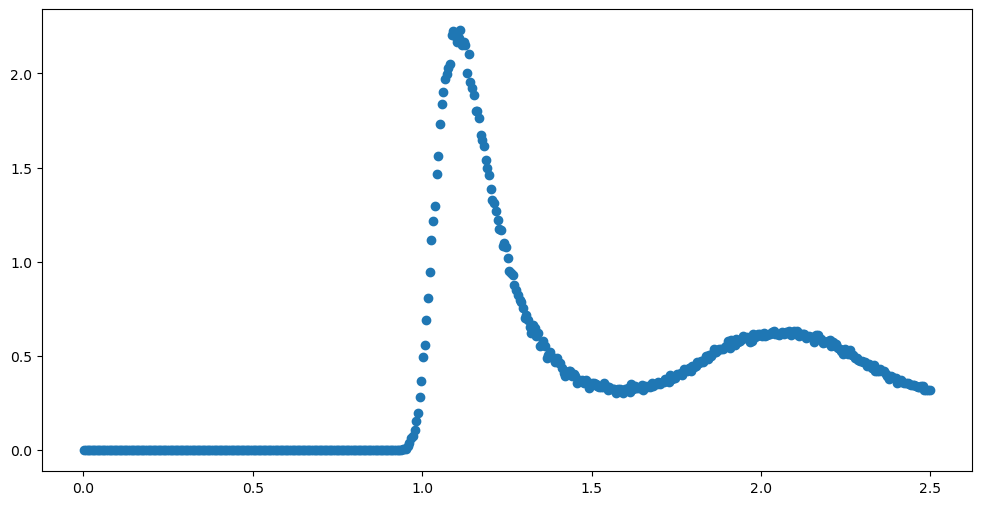

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(*rdf.T)


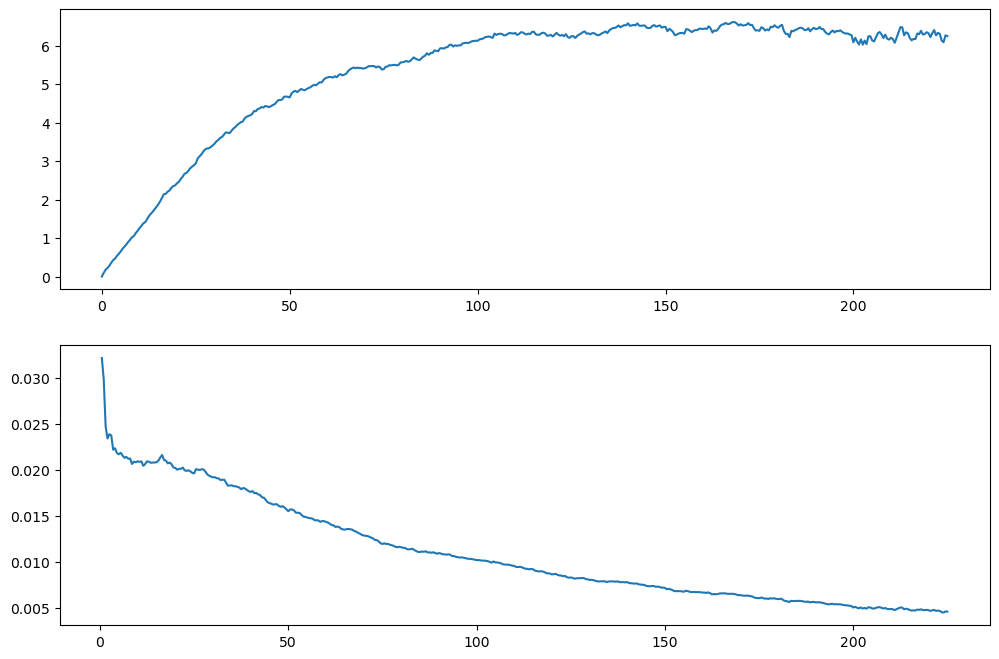

In [8]:
fig, ax = plt.subplots(2,figsize=(12,8))
ax[0].plot(msd[:, 0], msd[:, 1])
ax[1].plot(msd[:, 0], msd[:, 2])

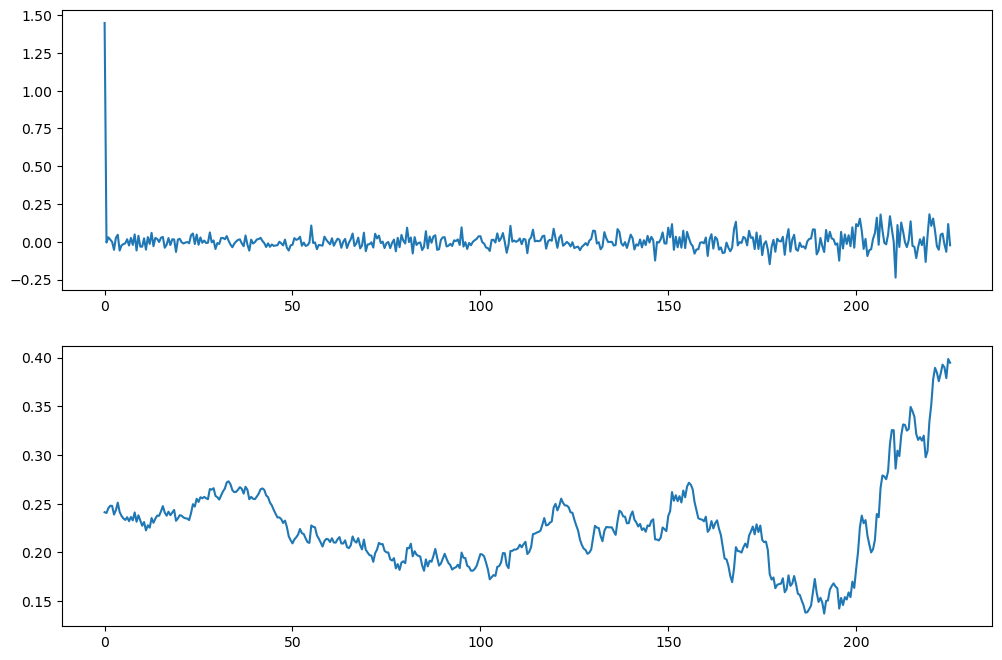

In [9]:
fig, ax = plt.subplots(2,figsize=(12,8))
ax[0].plot(msd[:, 0], msd[:, 3])
ax[1].plot(msd[:, 0], msd[:, 4])